---
# 1. SETUP

## Modules

In [1]:
import os
from Bio import Phylo, AlignIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec, lines
import scipy
import math
import numpy as np
import geopandas
import datetime
import shapely
import copy
from geopy import distance
import geopy
import cartopy.crs as ccrs
from augur import utils, export_v2
import subprocess
import itertools

from functions import *

## Paths

In [2]:
try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "prune", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    
results_dir = os.path.join(project_dir, "results/")

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

AUSPICE_PREFIX = "plague-phylogeography-projects_main_{}".format(PRUNE)

In [3]:
iqtree_dir    = os.path.join(results_dir, "iqtree/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))
lsd_dir       = os.path.join(results_dir, "lsd/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))
mugration_dir = os.path.join(results_dir, "mugration/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))
snippy_dir    = os.path.join(results_dir, "snippy_multi/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))

# ------------------------------------------
# Trees
divtree_path              = iqtree_dir    + "filter-taxa/iqtree.treefile"
timetree_path             = lsd_dir       + "lsd.timetree.nex"
#timetree_path             = lsd_dir       + "lsd.nex"
mugtree_country_path      = mugration_dir + "country.nex".format(MISSING_DATA)
mugtree_province_path     = mugration_dir + "province.nex".format(MISSING_DATA)
mugtree_branch_major_path = mugration_dir + "branch_major.nex".format(MISSING_DATA)
mugtree_branch_minor_path = mugration_dir + "branch_minor.nex".format(MISSING_DATA)
# ------------------------------------------
# Alignment
constant_sites_path   = results_dir + "snippy_multi/all/chromosome/full/snippy-multi.constant_sites.txt"
aln_path              = iqtree_dir + "filter-sites/snippy-multi.snps.aln"

# ------------------------------------------
# Metadata
auspice_config_path          = results_dir + "config/auspice_config.json"
metadata_path                = iqtree_dir    + "filter-taxa/metadata.tsv"
mugconf_country_path         = mugration_dir + "country_confidence.csv"
mugstates_country_path       = mugration_dir + "country_states.csv"
mugconf_province_path        = mugration_dir + "province_confidence.csv"
mugstates_province_path      = mugration_dir + "province_states.csv"
mugconf_branch_major_path    = mugration_dir + "branch_major_confidence.csv"
mugstates_branch_major_path  = mugration_dir + "branch_major_states.csv"
mugconf_branch_minor_path    = mugration_dir + "branch_minor_confidence.csv"
mugstates_branch_minor_path  = mugration_dir + "branch_minor_states.csv"


if PRUNE == "prune":
    full_divtree_path        = divtree_path.replace("prune", "full")
    full_metadata_path       = metadata_path.replace("prune", "full")
else:
    full_divtree_path        = divtree_path
    full_metadata_path       = metadata_path
    
# ------------------------------------------
# Output
auspice_dir = os.path.join(results_dir, "auspice/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))
if not os.path.exists(auspice_dir):
    subprocess.run(["mkdir", "-p", auspice_dir]) 
    #os.mkdir(out_dir)
auspice_remote_dir = os.path.join(project_dir, "auspice")
    
out_dir = os.path.join(results_dir, "augur/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))
if not os.path.exists(out_dir):
    subprocess.run(["mkdir", "-p", out_dir]) 
    #os.mkdir(out_dir)

## Variables

In [4]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

NO_DATA_CHAR = "NA"
UNKNOWN_CHAR = "?"
JSON_INDENT=2
CURRENT_YEAR = datetime.datetime.utcnow().year
MUG_CONF = 0.95
ALPHA = 0.05

# ------------------------------------------
# Alignment
with open(constant_sites_path) as infile:
    data = infile.read().strip().split(",")
    constant_sites = sum([int(count) for count in data])

aln = AlignIO.read(aln_path, "fasta")
variant_sites = len(aln[0].seq)
SEQ_LEN = constant_sites + variant_sites

# ------------------------------------------
# Geo
CRS = "epsg:3857"
CRS_EPSG = ccrs.epsg('3857')
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# ------------------------------------------
# Plotting
SM_FONT = 4
MED_FONT = 6
LG_FONT = 8
D3_PAL = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf" ]

# ------------------------------------------
BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"], 
    "0.PE": ["0.PE2", "0.PE4m", "0.PE4m", "0.PE4t", "0.PE4a", "0.PE5", "0.PE7", "0.PE8", "0.PE10"],   
    "0.ANT": ["0.ANT1", "0.ANT2","0.ANT3","0.ANT5"],     
    "1.PRE" : ["1.PRE0","1.PRE1", "1.PRE2", "1.PRE3"],    
    "1.ANT": ["1.ANT1"], 
    "1.IN": ["1.IN1","1.IN2","1.IN3"],   
    "1.ORI" : ["1.ORI1", "1.ORI2", "1.ORI3"],
    "2.ANT": ["2.ANT1","2.ANT2","2.ANT3" ], 
    "2.MED": ["2.MED0", "2.MED1","2.MED2","2.MED3" ], 
    "3.ANT": ["3.ANT1", "3.ANT2" ],     
    "4.ANT": ["4.ANT1" ],           
}

ANCIENT_BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"],  
    "1.PRE" : ["1.PRE1", "1.PRE2", "1.PRE3"],     
}

MUG_ATTRIBUTE_LIST = [
    "branch_major",
    "branch_minor",
    "country",
    "province",
]

---

# 2. IMPORT

## Mugration Confidence Tables

In [5]:
states_files = [mugstates_country_path, mugstates_province_path, mugstates_branch_major_path, mugstates_branch_minor_path]
conf_files = [mugconf_country_path, mugconf_province_path, mugconf_branch_major_path, mugconf_branch_minor_path]

# ----------------------------------------
# Convert character states to numbers
for mugstates,mugconf in zip(states_files, conf_files):
    node_i = 0
    conf_basename = os.path.splitext(mugconf)[0]
    conf_outname = conf_basename + "_tidy.csv"
    i = 0
    state_dict = {}
    with open(mugstates, "r") as infile:
        read_line = infile.readline()
        while read_line:
            split_line = read_line.strip().split(",")
            state = split_line[1]
            if state == "nan":
                state = "NA"
            if state == UNKNOWN_CHAR:
                state_dict[-1] = state
            else:
                state_dict[i] = state
                i += 1
            read_line = infile.readline()
    # Swap first to last place
    final_i = len(state_dict) - 1   
    state_dict[final_i] = "?"
    # Remove old first
    state_dict.pop(-1)

    with open(mugconf, "r") as infile:            
        i = 0
        read_line = infile.readline()
        header = read_line.strip().split(", ")
        header[0] = "name"

        data = ""
        for i in range(0, len(header) - 1):
            char = header[i + 1]
            header[i + 1] = state_dict[i]
        header = ",".join(header)
        read_line = infile.readline()            
        while read_line:
            # Rename internal nodes
            split_line = read_line.split(", ")
            node_name = split_line[0]
            if "NODE" in node_name:
                node_name = "NODE{}".format(node_i)
                node_i += 1
            new_line = ",".join([node_name] + split_line[1:])
            data += new_line
            read_line = infile.readline()
    
    with open(conf_outname, "w") as outfile:
        outfile.write(header + "\n")
        outfile.write(data)

# ----------------------------------------
# Import the tidy files as dataframes
mugconf_country_tidy_path = os.path.splitext(mugconf_country_path)[0] + "_tidy.csv"
mugconf_country_df = pd.read_csv(mugconf_country_tidy_path, sep=',', index_col = 0)

mugconf_province_tidy_path = os.path.splitext(mugconf_province_path)[0] + "_tidy.csv"
mugconf_province_df = pd.read_csv(mugconf_province_tidy_path, sep=',', index_col = 0)

mugconf_branch_major_tidy_path = os.path.splitext(mugconf_branch_major_path)[0] + "_tidy.csv"
mugconf_branch_major_df = pd.read_csv(mugconf_branch_major_tidy_path, sep=',', index_col = 0)

mugconf_branch_minor_tidy_path = os.path.splitext(mugconf_branch_minor_path)[0] + "_tidy.csv"
mugconf_branch_minor_df = pd.read_csv(mugconf_branch_minor_tidy_path, sep=',', index_col = 0)

## Trees

In [6]:
tree_paths = [divtree_path, timetree_path, mugtree_country_path, mugtree_province_path, mugtree_branch_major_path, mugtree_branch_minor_path  ]

for tree_path in tree_paths:
    tree_ext = os.path.splitext(tree_path)[1]
    if tree_ext == ".nwk" or tree_ext == ".newick" or tree_ext == ".treefile":
        tree = Phylo.read(tree_path, "newick")
    elif tree_ext == ".nex" or tree_ext == ".nexus":
        parse_trees = Phylo.parse(tree_path, "nexus")
        for parse_tree in parse_trees:
            clades = [c for c in parse_tree.find_clades()]
            if len(clades) > 1:
                break
        tree = parse_tree
    tree.ladderize(reverse=False)
    
    if tree_path == divtree_path:
        print("divtree:", os.path.basename(divtree_path))
        divtree = tree
    elif tree_path == timetree_path:
        print("timetree:", os.path.basename(timetree_path))        
        timetree = tree    
    elif tree_path == mugtree_country_path:
        print("mugtree_country:", os.path.basename(mugtree_country_path))       
        mugtree_country = tree    
    elif tree_path == mugtree_province_path:
        print("mugtree_province:",os.path.basename(mugtree_province_path))
        mugtree_province = tree  
    elif tree_path == mugtree_branch_major_path:
        print("mugtree_branch_major:",os.path.basename(mugtree_branch_major_path))        
        mugtree_branch_major = tree            
    elif tree_path == mugtree_branch_minor_path:
        print("mugtree_branch_minor:",os.path.basename(mugtree_branch_minor_path))        
        mugtree_branch_minor = tree                
    
full_divtree = Phylo.read(full_divtree_path, "newick")
full_divtree.ladderize(reverse=False)

divtree: iqtree.treefile
timetree: lsd.timetree.nex
mugtree_country: country.nex
mugtree_province: province.nex
mugtree_branch_major: branch_major.nex
mugtree_branch_minor: branch_minor.nex


## Genomic Metadata

In [7]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
metadata_df.set_index(metadata_df.columns[0], inplace=True)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

full_metadata_df = pd.read_csv(full_metadata_path, sep='\t')
full_metadata_df.set_index(full_metadata_df.columns[0], inplace=True)
full_metadata_df.fillna(NO_DATA_CHAR, inplace=True)

---
# 3. MERGE METADATA

In [8]:
# Check if they're synchronized
node_i = 0

metadata_df["branch_support_char"] = [""] * len(metadata_df)

for cd,ct,cmc,cmp,cmbmaj, cmbmin in zip(
        divtree.find_clades(), 
        timetree.find_clades(), 
        mugtree_country.find_clades(),
        mugtree_province.find_clades(),
        mugtree_branch_major.find_clades(),    
        mugtree_branch_minor.find_clades(),      
    ):
    # Rename internal nodes
    if not cd.name or "NODE" in cmc.name:
        cd.name = "NODE{}".format(node_i)
        ct.name = "NODE{}".format(node_i)
        cmc.name = "NODE{}".format(node_i) 
        cmp.name = "NODE{}".format(node_i) 
        cmbmaj.name = "NODE{}".format(node_i) 
        cmbmin.name = "NODE{}".format(node_i) 
        node_i += 1
        
    if cd.name != ct.name or cd.name != cmc.name or cd.name != cmp.name:
        print("ERROR. Trees are not synchronized.")
        print(cd.name, ct.name, cmc.name, cmp.name, cmbmaj.name, cmbmin.name)
        break
        
    node_name = cd.name
    
    # node type
    node_type = "internal"
    if cd.is_terminal():
        node_type = "terminal"
    metadata_df.at[node_name, "node_type"] = node_type

    
    # Branch Length
    branch_length = cd.branch_length
    if not branch_length:
        branch_length = 0
    metadata_df.at[node_name, "branch_length"] = branch_length
    # Branch Support
    # Give terminal nodes 100% confidence
    branch_support = cd.confidence
    if cd.is_terminal():
        branch_support = 100
        
    # Internal nodes without confidence can be 0
    elif not cd.confidence:
        branch_support = 0
    metadata_df.at[node_name, "branch_support"] = branch_support
    
    if branch_support >= 95 and not cd.is_terminal():
        branch_support_char = "*"
        metadata_df.at[node_name, "branch_support_char"] = branch_support_char

    if branch_support >= 95:
        metadata_df.at[node_name, "branch_support_conf_category"] = "HIGH"
    else:
        metadata_df.at[node_name, "branch_support_conf_category"] = "LOW"        
    
    
    comment_dict = {}
    # Mugration  Country
    if cmc.comment:
        cmc_comment_dict = parse_comment(cmc.comment)
        for attr in cmc_comment_dict:
            comment_dict["mugration_" + attr] = cmc_comment_dict[attr]
            
    # Mugration  Province
    if cmp.comment:
        cmp_comment_dict = parse_comment(cmp.comment)
        for attr in cmp_comment_dict:
            comment_dict["mugration_" + attr] = cmp_comment_dict[attr]            
            
    # Mugration Branch Major
    if cmbmaj.comment:
        cmbmaj_comment_dict = parse_comment(cmbmaj.comment)
        for attr in cmbmaj_comment_dict:
            comment_dict["mugration_" + attr] = cmbmaj_comment_dict[attr]            
            
    # Mugration Branch Minor
    if cmbmin.comment:
        cmbmin_comment_dict = parse_comment(cmbmin.comment)
        for attr in cmbmin_comment_dict:
            comment_dict["mugration_" + attr] = cmbmin_comment_dict[attr]              

    # Time Tree         
    if ct.comment:
        ct_comment_dict = parse_comment(ct.comment)
        for attr in ct_comment_dict:
            comment_dict["timetree_" + attr] = ct_comment_dict[attr]
            
    for attr in comment_dict:
        metadata_df.at[node_name, attr] = comment_dict[attr]
           
metadata_df.fillna(NO_DATA_CHAR, inplace=True)
#display(metadata_df)

## Add Mugration Confidence and Handle Root

In [9]:
df_list = [mugconf_country_df, mugconf_province_df, mugconf_branch_major_df, mugconf_branch_minor_df]
attr_list = ["country", "province", "branch_major", "branch_minor"]

for df,attr in zip(df_list, attr_list):
    for sample in df.index:
        max_state = ""
        max_val = 0        
        for state,val in zip(df.columns, df.loc[sample]):
            if val >= max_val:
                max_val = val
                max_state = state
        metadata_df.at[sample,"mugration_" + attr] = max_state      
        metadata_df.at[sample,"mugration_" + attr + "_confidence"] = round(max_val,2)
        
        # if the attr is country or province, extend this confidence to lat and lon
        if attr == "country" or attr == "province":
            metadata_df.at[sample,"mugration_" + attr + "_lat_confidence"] = max_val
            metadata_df.at[sample,"mugration_" + attr + "_lon_confidence"] = max_val

display(metadata_df.loc["NODE0"])
#print(list(metadata_df["mugration_branch_minor_confidence"]))

strain                                     NA
date                                       NA
date_bp                                    NA
country                                    NA
province                                   NA
                                       ...   
mugration_province_confidence            0.37
mugration_province_lat_confidence    0.369092
mugration_province_lon_confidence    0.369092
mugration_branch_major_confidence         0.5
mugration_branch_minor_confidence        0.29
Name: NODE0, Length: 41, dtype: object

## Add Mugration P-Value

In [10]:
"""divtree_copy = copy.deepcopy(divtree)

for attr in MUG_ATTRIBUTE_LIST:
    #if attr != "country" and attr != "province": continue
    if attr != "country": continue
    
    metadata_df["mugration_" + attr + "_transition_pvalue"] = [NO_DATA_CHAR] * len(metadata_df)
    metadata_df["mugration_" + attr + "_transition_conf_category"] = [NO_DATA_CHAR] * len(metadata_df)
    
    # There are too many states in the full tree to do permutations
    # But mugration is estimated from the full tree
    # If a subtree is not monophyletic, it's root could be a state not observed
    # Leave the subtree root as NA?
        
    # Sub Trees
    for branch in BRANCH_LIST:
        
        print(attr, branch)
        
        # Extract subtree
        # Create the subtree df
        subtree_df = metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[branch])]
        if len(subtree_df) < 2: continue
        subtree_tips = subtree_df[subtree_df["node_type"] == "terminal"]
        subtree_all = metadata_df[metadata_df["mugration_branch_minor"].isin(BRANCH_LIST[branch])]
    
        subtree = extract_subtree(
            tree=divtree_copy, 
            tips=list(subtree_tips.index), 
            df=metadata_df, 
            color_branches=False)  
        
        states = list(subtree_tips["mugration_" + attr])
        states_uniq = set(states)
        # Static transitions in place
        transitions = [(s,s) for s in states_uniq]
        # Add movements
        transitions += list(itertools.permutations(states, 2))
        transitions_uniq = set(transitions)
        transitions_dict = {t: transitions.count(t) / len(transitions) for t in transitions_uniq}

        for rec in subtree_all.iterrows():
            sample = rec[0]
            # Check that this rec is in the subtree
            if sample not in [c.name for c in subtree.find_clades()]:
                continue
                
            # Get parent
            walk_path = [subtree.root] + subtree.get_path(sample)
            # Root
            if len(walk_path) == 1:
                parent = walk_path[0]
            else:
                parent = walk_path[-2]
                        
                
            # Get transition based on parent and node
            state = metadata_df["mugration_" + attr][sample]
            parent_state = metadata_df["mugration_" + attr][parent.name]
            transition = (parent_state, state) 
            
            # Check that the parent state is in the dictionary
            if parent_state not in states: continue
                
            pvalue = transitions_dict[transition]
            
            # Get mugration confidence
            conf = metadata_df["mugration_" + attr + "_confidence"][sample]
            
            # If conf >= 0.95 and pvalue < 0.05
            conf_category = "LOW"
            if conf >= MUG_CONF and pvalue < ALPHA:
                conf_category = "HIGH"                
            
            # Add to database
            metadata_df.at[sample, "mugration_" + attr + "_transition_pvalue"] = pvalue
            metadata_df.at[sample, "mugration_" + attr + "_transition_conf_category"] = conf_category
    
display(metadata_df)"""

'divtree_copy = copy.deepcopy(divtree)\n\nfor attr in MUG_ATTRIBUTE_LIST:\n    #if attr != "country" and attr != "province": continue\n    if attr != "country": continue\n    \n    metadata_df["mugration_" + attr + "_transition_pvalue"] = [NO_DATA_CHAR] * len(metadata_df)\n    metadata_df["mugration_" + attr + "_transition_conf_category"] = [NO_DATA_CHAR] * len(metadata_df)\n    \n    # There are too many states in the full tree to do permutations\n    # But mugration is estimated from the full tree\n    # If a subtree is not monophyletic, it\'s root could be a state not observed\n    # Leave the subtree root as NA?\n        \n    # Sub Trees\n    for branch in BRANCH_LIST:\n        \n        print(attr, branch)\n        \n        # Extract subtree\n        # Create the subtree df\n        subtree_df = metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[branch])]\n        if len(subtree_df) < 2: continue\n        subtree_tips = subtree_df[subtree_df["node_type"] == "terminal"]\n  

## Latitude and Longtitude

In [11]:
latlon_country_df = pd.DataFrame()
latlon_province_df = pd.DataFrame()

df_list = [latlon_country_df, latlon_province_df]
attr_list = ["country", "province"]
conf_df_list = [mugconf_country_df, mugconf_province_df]

# Create a mapping of geo name to lat,lon
for df,attr in zip(df_list, attr_list):
    # Get data
    for rec in metadata_df.iterrows():
        node_name = rec[0]
        node_type = rec[1]["node_type"]
        name = rec[1][attr]
        country = rec[1]["country"]
        
        if node_type == "internal":
            continue
        
        if attr == "province" and name == NO_DATA_CHAR and node_type == "terminal" and country != "Russia":
            # Use country instead
            name = rec[1]["country"]
            lat = rec[1]["country_lat"]
            lon = rec[1]["country_lon"]
        else:
            lat = rec[1][attr + "_lat"]
            lon = rec[1][attr + "_lon"]             


        if name not in df.index:
            df.at[name, "lat"] = lat
            df.at[name, "lon"] = lon
            df.at[name, "size"] = 1
        else:
            df["size"][name] += 1

#display(latlon_country_df)
#display(latlon_province_df)


# Update lat lon for mugration
for latlon_df, conf_df, attr in zip(df_list, conf_df_list, attr_list):
    for rec in metadata_df.iterrows():
        sample = rec[0]
        name = rec[1]["mugration_" + attr]  
        node_type = rec[1]["node_type"]  
        country = rec[1]["country"]  
        
        if attr == "province" and rec[1][attr]  == NO_DATA_CHAR and node_type == "terminal" and country != "Russia":
            # Use country instead
            name = rec[1]["country"]
            metadata_df.at[sample,"mugration_" + attr] = name
        
        lat = latlon_df["lat"][name]
        lon = latlon_df["lon"][name]
        
                
        metadata_df.at[sample, "mugration_" + attr +"_lat"] = lat
        metadata_df.at[sample, "mugration_" + attr +"_lon"] = lon
        
        
# Mapping file for auspice
out_path_latlon = os.path.join(out_dir, "latlon.tsv")

# Countries
with open(out_path_latlon, "w") as outfile:
    for country in latlon_country_df.index:
        lat = str(latlon_country_df["lat"][country])
        lon = str(latlon_country_df["lon"][country])
        outfile.write("country" + "\t" + country + "\t" + lat + "\t" + lon + "\n")
# Provinces
with open(out_path_latlon, "a") as outfile:
    for province in latlon_province_df.index:
        lat = str(latlon_province_df["lat"][province])
        lon = str(latlon_province_df["lon"][province])
        outfile.write("province" + "\t" + province + "\t" + lat + "\t" + lon + "\n")
        
#display(metadata_df[metadata_df["continent"] == "Africa"])

## Convert Dataframe to Geopandas

<GeoAxesSubplot:>

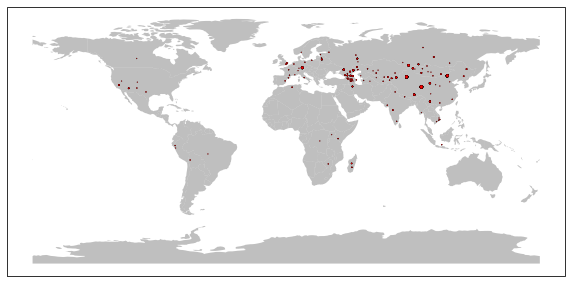

In [12]:
geometry = []

for rec in metadata_df.iterrows():
    sample = rec[0]
    # Terminal nodes use the "lat/lon" attribute        
    if rec[1]["node_type"] == "terminal":  
        province = rec[1]["province"]
        country = rec[1]["country"]
        if province != NO_DATA_CHAR:
            attr = "province"
            name = province
        else:
            attr = "country"
            name = country
        lat = rec[1]["lat"]
        lon = rec[1]["lon"]
    # Internal nodes use mugration province
    else:
        name = rec[1]["mugration_province"]
        lat  = rec[1]["mugration_province_lat"]
        lon  = rec[1]["mugration_province_lon"]     
    
    if attr == "province":
        size = latlon_province_df["size"][name]
    elif attr == "country":
        size = latlon_country_df["size"][name]
    point = shapely.geometry.Point(lon,lat)
    geometry.append(point)


metadata_gdf = geopandas.GeoDataFrame(metadata_df, crs="epsg:3857", geometry=geometry)

# Add geometry size
for rec in metadata_gdf.iterrows():
    sample = rec[0]
    name = rec[1]["mugration_" + attr]
    size = latlon_df["size"][name]  
    metadata_gdf.at[sample, "geometry_size"] = size
    


# Test map

# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=(10, 5))
world_polygons.plot(ax=ax, color="grey", alpha=0.5)
metadata_gdf.plot(ax=ax, c="red", markersize="geometry_size", ec="black", lw=0.25)

## Add Sub  and Spread Rate

In [13]:
# 1. Get Branch Lengths in Num Substitutions

metadata_gdf["branch_length_sub"] = [NO_DATA_CHAR] * len(metadata_gdf)
metadata_gdf["branch_length_time"] = [NO_DATA_CHAR] * len(metadata_gdf)
metadata_gdf["sub_rate"] = [NO_DATA_CHAR] * len(metadata_gdf)
metadata_gdf["geo_rate_sub"] = [NO_DATA_CHAR] * len(metadata_gdf)
metadata_gdf["geo_rate_time"] = [NO_DATA_CHAR] * len(metadata_gdf)

for c in divtree.find_clades():
    branch_length_sub = c.branch_length * SEQ_LEN
    branch_length_time = timetree.common_ancestor(c.name).branch_length
    walk_path = [divtree.root] + divtree.get_path(c)
    # Root
    if len(walk_path) == 1:
        parent = walk_path[0]
    else:
        parent = walk_path[-2]
    coord1 = metadata_gdf["geometry"][parent.name]
    coord2 = metadata_gdf["geometry"][c.name]
    geo_dist = geopy.distance.great_circle([coord1.y, coord1.x], [coord2.y, coord2.x]).km
    # 1. Rate as KM / subs / site
    geo_rate_sub = geo_dist / branch_length_sub if branch_length_sub != 0 else 0
    # 2. Rate as KM / time
    geo_rate_time = geo_dist / branch_length_time if branch_length_time != 0 else 0
    # 3. Rate as subs/year
    rate_sub = branch_length_sub / branch_length_time  if branch_length_time != 0 else 0
    metadata_gdf.at[c.name,"branch_length_sub"] = branch_length_sub
    metadata_gdf.at[c.name,"branch_length_time"] = branch_length_time
    metadata_gdf.at[c.name,"rate_sub"] = rate_sub
    metadata_gdf.at[c.name,"rate_geo_sub"] = geo_rate_sub
    metadata_gdf.at[c.name,"rate_geo_time"] = geo_rate_time
     
#display(metadata_gdf)

rates = list(metadata_gdf["rate_sub"])
rates_ci = np.array(
    np.percentile(
        np.array(rates), (0.05, 95), axis=0
    )
)
print(rates_ci)

[0.         0.18930392]


In [14]:
"""

# ----------------
fig, axes = plt.subplots(1,4, figsize=(12,3))
fig.subplots_adjust(wspace=0.5)

for ax in axes:
    ax.set_xlabel("Rate (sub/year)")
    ax.set_ylabel("Density")

ax_i = -1

# Empirical Data
ax_i += 1
ax = axes[ax_i]
stddev = 0.01
mean = 0
loc = 0

rates = list(metadata_gdf["rate_sub"])
#sns.distplot(rates, ax=ax)
sns.kdeplot(rates, ax=ax)
#sns.histplot(rates, ax=ax)
ax.set_xlim(0,0.2)

shape, loc, scale = scipy.stats.lognorm._fitstart(rates) 
print(loc, shape, scale)
shape, loc, scale = scipy.stats.lognorm.fit(rates) 
print(loc, shape, scale)

# Strict clock (mean 0, stdev ~0)
x=np.linspace(0.95,1.05,100)
ax_i += 1
ax = axes[ax_i]
stddev = 0.01
mean = 0
dist = scipy.stats.lognorm([stddev],loc=mean)
ax.plot(x, dist.pdf(x))
ax.set_xlim(0.95,1.05)
ax.set_title("Strict Clock")

# Relaxed Clock (mean 0, stdev 0.2)
ax_i += 1
ax = axes[ax_i]
x=np.linspace(0,2,100)
stddev = 0.2
mean = 0
dist = scipy.stats.lognorm([stddev],loc=mean)
ax.plot(x, dist.pdf(x))
ax.set_xlim(0,2)
ax.set_title("Relaxed Clock (stddev=0.2)")

# Relaxed Clock (mean 0, stdev 1)
ax_i += 1
ax = axes[ax_i]
x=np.linspace(0,5,100)
stddev = 1
mean = 0
dist = scipy.stats.lognorm([stddev],loc=mean)
ax.plot(x, dist.pdf(x))
ax.set_xlim(0,5)
ax.set_title("Relaxed Clock (stddev=1)")"""

'\n\n# ----------------\nfig, axes = plt.subplots(1,4, figsize=(12,3))\nfig.subplots_adjust(wspace=0.5)\n\nfor ax in axes:\n    ax.set_xlabel("Rate (sub/year)")\n    ax.set_ylabel("Density")\n\nax_i = -1\n\n# Empirical Data\nax_i += 1\nax = axes[ax_i]\nstddev = 0.01\nmean = 0\nloc = 0\n\nrates = list(metadata_gdf["rate_sub"])\n#sns.distplot(rates, ax=ax)\nsns.kdeplot(rates, ax=ax)\n#sns.histplot(rates, ax=ax)\nax.set_xlim(0,0.2)\n\nshape, loc, scale = scipy.stats.lognorm._fitstart(rates) \nprint(loc, shape, scale)\nshape, loc, scale = scipy.stats.lognorm.fit(rates) \nprint(loc, shape, scale)\n\n# Strict clock (mean 0, stdev ~0)\nx=np.linspace(0.95,1.05,100)\nax_i += 1\nax = axes[ax_i]\nstddev = 0.01\nmean = 0\ndist = scipy.stats.lognorm([stddev],loc=mean)\nax.plot(x, dist.pdf(x))\nax.set_xlim(0.95,1.05)\nax.set_title("Strict Clock")\n\n# Relaxed Clock (mean 0, stdev 0.2)\nax_i += 1\nax = axes[ax_i]\nx=np.linspace(0,2,100)\nstddev = 0.2\nmean = 0\ndist = scipy.stats.lognorm([stddev],loc

## Colors

In [15]:
out_path_colors = os.path.join(out_dir, "colors.tsv")

colors_dict = {}

for attr in MUG_ATTRIBUTE_LIST:
    # Create the color map
    attr_key = attr.lower()
    colors_dict[attr_key] = {}
    for t in full_divtree.get_terminals():
        attr_val = full_metadata_df[attr][t.name]
        # Remove the letter suffix from branch_minor
        if attr == "branch_minor":
            while attr_val[-1].isalpha():
                attr_val = attr_val[:-1] 
        if attr_val not in colors_dict[attr_key] and attr_val != NO_DATA_CHAR:
            colors_dict[attr_key][attr_val] = {}
            
    # Create the custom color map (pyplot)
    cmap = plt.get_cmap("rainbow", len(colors_dict[attr_key]))
    # Convert the color map to a list of RGB values
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # Convert RGB values to hex colors
    attr_hex = [colors.to_hex(col) for col in cmaplist]
    
    # Assign colors to value
    for attr_val, attr_col in zip(colors_dict[attr_key], attr_hex):
        colors_dict[attr_key][attr_val] = attr_col   
        
    # Add unknown
    colors_dict[attr_key][UNKNOWN_CHAR] = "#969696"
    
print(colors_dict)

with open(out_path_colors, "w") as outfile:
    for attr_key in colors_dict:
        for attr_val in colors_dict[attr_key]:
            outfile.write(str(attr_key) + "\t" + str(attr_val) + "\t" + str(colors_dict[attr_key][attr_val]) + "\n")

{'branch_major': {'0.PRE': '#8000ff', '0.PE': '#4c4ffc', '0.ANT': '#1996f3', '3.ANT': '#1acee3', '4.ANT': '#4df3ce', '2.ANT': '#80ffb4', '2.MED': '#b3f396', '1.PRE': '#e6ce74', '1.ANT': '#ff964f', '1.IN': '#ff4f28', '1.ORI': '#ff0000', '?': '#969696'}, 'branch_minor': {'0.PRE2': '#8000ff', '0.PRE1': '#7018ff', '0.PE7': '#6130fe', '0.PE2': '#5148fc', '0.PE8': '#425ffa', '0.PE10': '#3275f8', '0.PE4': '#238af5', '0.PE5': '#139ef1', '0.ANT1': '#04b0ed', '0.ANT4': '#0cc1e8', '0.ANT5': '#1bd0e3', '0.ANT2': '#2bdddd', '0.ANT3': '#3ae8d7', '3.ANT1': '#49f1d0', '3.ANT2': '#59f8c8', '4.ANT1': '#68fcc1', '2.ANT3': '#78ffb9', '2.ANT2': '#87ffb0', '2.ANT1': '#97fca7', '2.MED0': '#a6f89e', '2.MED3': '#b6f194', '2.MED2': '#c5e88a', '2.MED1': '#d5dd7f', '1.PRE0': '#e4d075', '1.PRE1': '#f3c16a', '1.PRE2': '#ffb05f', '1.PRE3': '#ff9e53', '1.ANT1': '#ff8a48', '1.IN1': '#ff753c', '1.IN2': '#ff5f30', '1.IN3': '#ff4824', '1.ORI2': '#ff3018', '1.ORI1': '#ff180c', '1.ORI3': '#ff0000', '?': '#969696'}, 'countr

## Parse Tree Into Dataframe

In [16]:
x_posns = get_x_positions(divtree)
y_posns = get_y_positions(divtree)

# Initialize 
# Date lower and upper error bars for tips
metadata_gdf["date_lower"] = [NO_DATA_CHAR] * len(metadata_gdf)
metadata_gdf["date_upper"] = [NO_DATA_CHAR] * len(metadata_gdf)
    
for c in divtree.find_clades():
    # ------------------------------------------------------------
    # Coordinates for the divergence tree
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    metadata_gdf.at[c.name, 'divtree_coord_x'] = coord_x
    metadata_gdf.at[c.name, 'divtree_coord_y'] = coord_y
    
    # ------------------------------------------------------------
    # Root to tip distance (same as div x)
    metadata_gdf.at[c.name, "rtt_dist"] = coord_x
    
    # ------------------------------------------------------------
    # Branch Major and Branch Minor and Colors
    branch_minor = metadata_gdf["mugration_branch_minor"][c.name]
    if branch_minor != NO_DATA_CHAR:
        # Remove letters at end
        while branch_minor[-1].isalpha():
            branch_minor = branch_minor[:-1]    
    metadata_gdf.at[c.name, "mugration_branch_minor"] = branch_minor
    branch_major = metadata_gdf["mugration_branch_major"][c.name]
    branch_major_color = colors_dict["branch_major"][branch_major]
    metadata_gdf.at[c.name, "branch_major_color"] = branch_major_color    

    # ------------------------------------------------------------
    # Date lower and upper error bars for tips
    date_mean = metadata_gdf["date_mean"][c.name] 
    if date_mean != NO_DATA_CHAR:
        metadata_gdf.at[c.name, "date_lower"] = date_mean - metadata_gdf["date_err"][c.name]
        metadata_gdf.at[c.name, "date_upper"] = date_mean + metadata_gdf["date_err"][c.name]

x_posns = get_x_positions(timetree)
y_posns = get_y_positions(timetree)


for c in timetree.find_clades():

    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    metadata_gdf.at[c.name, 'timetree_coord_x'] = coord_x
    metadata_gdf.at[c.name, 'timetree_coord_y'] = coord_y
    
    timetree_date = int(float(metadata_gdf["timetree_date"][c.name]))
    timetree_date_calendar = CURRENT_YEAR + timetree_date
    metadata_gdf.at[c.name, 'timetree_date_calendar'] = timetree_date_calendar
    
    timetree_CI_date = metadata_gdf["timetree_CI_date"][c.name]
    if timetree_CI_date == NO_DATA_CHAR:
        timetree_CI_lower_err = 0
        timetree_CI_upper_err = 0
    else:
        timetree_CI_split = [int(float(d)) for d in timetree_CI_date.strip("{}").split(",")]
        timetree_CI_calendar = [CURRENT_YEAR + d for d in timetree_CI_split]
        timetree_CI_lower_err = timetree_date_calendar - timetree_CI_calendar[0]
        timetree_CI_upper_err = timetree_CI_calendar[1] - timetree_date_calendar
    metadata_gdf.at[c.name,"timetree_CI_lower_err"] = timetree_CI_lower_err
    metadata_gdf.at[c.name,"timetree_CI_upper_err"] = timetree_CI_upper_err   

#display(metadata_gdf)

## Create Custom Columns

In [17]:
metadata_gdf["country_date_strain"] = [NO_DATA_CHAR] * len(metadata_gdf)
metadata_gdf["province_date_strain"] = [NO_DATA_CHAR] * len(metadata_gdf)

for c in divtree.get_terminals():
    strain = metadata_gdf["strain"][c.name]
    country = metadata_gdf["country"][c.name]
    province = metadata_gdf["country"][c.name]
    date = metadata_gdf["date"][c.name]
    if type(date) == str:
        date = date.strip("[]")
    metadata_gdf.at[c.name,"country_date_strain"] = "{} ({}) {}".format(country, date, strain)
    metadata_gdf.at[c.name,"province_date_strain"] = "{} ({}) {}".format(province, date, strain)

## Calculate Stats

In [18]:
metadata_gdf["root_rtt_dist"] = [NO_DATA_CHAR] * len(metadata_gdf)
metadata_gdf["clade_rtt_dist"] = [NO_DATA_CHAR] * len(metadata_gdf)

branch_mrca_dict = {}

for c in divtree.find_clades():
    sample = c.name    
    # Clade MRCA Dist    
    branch_major = metadata_gdf["mugration_branch_major"][sample]
    if branch_major in branch_mrca_dict: continue

    branch_df = metadata_gdf[metadata_gdf["mugration_branch_major"] == branch_major]
    branch_mrca = branch_df[branch_df["node_type"] == "internal"].iloc[0].name
    branch_mrca_dict[branch_major] = branch_mrca
    

for c in divtree.find_clades():
    sample = c.name
    # Root Dist
    root_dist = divtree.distance(divtree.root, c)
    
    # Clade MRCA Dist    
    branch_major = metadata_gdf["mugration_branch_major"][sample]
    branch_mrca = branch_mrca_dict[branch_major]
    branch_mrca_dist = divtree.distance(branch_mrca, c)
    
    metadata_gdf.at[sample, "root_rtt_dist"] = root_dist
    metadata_gdf.at[sample, "clade_rtt_dist"] = branch_mrca_dist

---
# 4. EXPORT

## Time Tree

In [19]:
out_timetree = copy.deepcopy(timetree)

for c in out_timetree.find_clades():
    if not c.confidence:
        c.confidence = 0

metadata_to_comment(out_timetree, metadata_gdf)    
out_timetree_nex_path = os.path.join(out_dir, "all.timetree.nex")
Phylo.write(out_timetree, out_timetree_nex_path, "nexus")

for c in out_timetree.find_clades():
    c.comment = None

out_timetree_nwk_path = os.path.join(out_dir, "all.timetree.nwk")
Phylo.write(out_timetree, out_timetree_nwk_path, "newick")

1

# Divergence Tree

In [20]:
out_divtree = copy.deepcopy(divtree)

for c in out_divtree.find_clades():
    if not c.confidence:
        c.confidence = 0

metadata_to_comment(out_divtree, metadata_gdf)    
out_divtree_nex_path = os.path.join(out_dir, "all.divtree.nex")
Phylo.write(out_divtree, out_divtree_nex_path, "nexus", format_branch_length="%1.10f")

for c in out_divtree.find_clades():
    c.comment = None

out_divtree_nwk_path = os.path.join(out_dir, "all.divtree.nwk")
Phylo.write(out_divtree, out_divtree_nwk_path, "newick", format_branch_length="%1.10f")

1

## Metadata

In [21]:
out_path_metadata = out_divtree_nwk_path = os.path.join(out_dir, "metadata.tsv")
metadata_gdf.to_csv(out_path_metadata, sep="\t", index=True)

## Augur

### Reduced Dataframe

In [22]:
# Remember, order atters when dealing with confidence!

columns = [
    # Draw Divergence Tree
    "branch_length",
    "branch_length_sub",
    # Draw Time Tree
    "branch_length_time",
    "timetree_date_calendar",
    # Draw Country Map
    "mugration_country",
    "mugration_country_confidence",    
    "mugration_country_lat",   
    "mugration_country_lat_confidence",
    "mugration_country_lon",  
    "mugration_country_lon_confidence", 
    #"mugration_country_transition_pvalue",
    #"mugration_country_transition_conf_category",      
    # Draw Province Map
    "mugration_province",
    "mugration_province_confidence",    
    "mugration_province_lat",   
    "mugration_province_lat_confidence",
    "mugration_province_lon",  
    "mugration_province_lon_confidence",    
    #"mugration_province_transition_pvalue",
    #"mugration_province_transition_conf_category",    
    # Colors and Filters
    "mugration_branch_major",
    "mugration_branch_major_confidence",
    "mugration_branch_minor",
    "mugration_branch_minor_confidence",   
    "branch_number",
    "branch_support",
    "branch_support_conf_category",    
    "continent",
    "node_type",
    "geometry_size",
    # Text Description
    "biosample_accession",
    "strain",
    "country_date_strain",
    "province_date_strain",
    # Tip Dates
    "date_mean",
    "date_err",
    "date_bp_mean",
    # Stats
    "root_rtt_dist",
    "clade_rtt_dist",
    "rate_sub",
    "rate_geo_sub",
    "rate_geo_time" 
]

# Edit df
auspice_gdf = copy.copy(metadata_gdf[columns])
auspice_gdf["timetree_num_date_confidence"] = [NO_DATA_CHAR] * len(auspice_gdf)
auspice_gdf["node_name"] = list(auspice_gdf.index)
auspice_gdf["blank"] = [" "] * len(auspice_gdf)

for attr in MUG_ATTRIBUTE_LIST:
    col = attr + "_conf_category"
    auspice_gdf[col] = ["NA"] * len(auspice_gdf)
    for rec in auspice_gdf.iterrows():
        sample = rec[0]
        conf = auspice_gdf["mugration_" + attr + "_confidence"][sample]
        if conf >= 0.95:
            category = "HIGH"
        elif conf < 0.95:
            category = "LOW"
        auspice_gdf.at[sample, col] = category

for rec in metadata_gdf.iterrows():
    sample = rec[0]
    date = rec[1]["timetree_date_calendar"]
    date_lower = float(date) - rec[1]["timetree_CI_lower_err"]
    date_upper = float(date) + rec[1]["timetree_CI_upper_err"]
    #date_confidence = "{}:{}".format(date_lower, date_upper)
    date_confidence = [date_lower, date_upper]
    auspice_gdf.at[sample,"timetree_num_date_confidence"] = date_confidence
    # Rounding
    auspice_gdf.at[sample, "branch_length_sub"] = round(auspice_gdf["branch_length_sub"][sample])
    auspice_gdf.at[sample, "branch_length_time"] = round(auspice_gdf["branch_length_time"][sample])
    #auspice_gdf.at[sample, "mugration_country_transition_pvalue"] = round(auspice_gdf["mugration_country_transition_pvalue"][sample],2)
    #auspice_gdf.at[sample, "mugration_province_transition_pvalue"] = round(auspice_gdf["mugration_province_transition_pvalue"][sample],2)

auspice_gdf.rename(columns={"timetree_date_calendar": "timetree_num_date"}, inplace=True)
#auspice_gdf.rename(columns={"mugration_country_transition_pvalue": "country_transition_pvalue"}, inplace=True)
#auspice_gdf.rename(columns={"mugration_province_transition_pvalue": "province_transition_pvalue"}, inplace=True)
#auspice_gdf.rename(columns={"mugration_country_transition_conf_category": "country_transition_conf_category"}, inplace=True)
#auspice_gdf.rename(columns={"mugration_province_transition_conf_category": "province_transition_conf_category"}, inplace=True)
display(auspice_gdf)

,branch_length,branch_length_sub,branch_length_time,timetree_num_date,mugration_country,mugration_country_confidence,mugration_country_lat,mugration_country_lat_confidence,mugration_country_lon,mugration_country_lon_confidence,mugration_province,mugration_province_confidence,mugration_province_lat,mugration_province_lat_confidence,mugration_province_lon,mugration_province_lon_confidence,mugration_branch_major,mugration_branch_major_confidence,mugration_branch_minor,mugration_branch_minor_confidence,branch_number,branch_support,branch_support_conf_category,continent,node_type,geometry_size,biosample_accession,strain,country_date_strain,province_date_strain,date_mean,date_err,date_bp_mean,root_rtt_dist,clade_rtt_dist,rate_sub,rate_geo_sub,rate_geo_time,timetree_num_date_confidence,node_name,blank,branch_major_conf_category,branch_minor_conf_category,country_conf_category,province_conf_category
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,3.774600e-06,16,183,1992.0,United States of America,1.00,39.783730,1.000000,-100.445882,1.000000,Colorado,1.00,38.725178,1.000000,-105.607716,1.000000,1.ORI,1.0,1.ORI1,1.0,1,100.0,HIGH,North America,terminal,1.0,SAMEA1705942,CO92,United States of America (1992) CO92,United States of America (1992) CO92,1992,0,29,6.63842e-05,5.7539e-06,0.087238,45.820070,3.997273,"[1992.0, 1992.0]",Reference,,HIGH,HIGH,HIGH,HIGH
GCA_009909635.1_ASM990963v1_genomic,1.817000e-06,8,504,1923.0,Russia,1.00,64.686314,1.000000,97.745306,1.000000,Rostov Oblast,1.00,47.622245,1.000000,40.795794,1.000000,2.MED,1.0,2.MED1,1.0,2,100.0,HIGH,Europe,terminal,3.0,SAMN13632815,9_10,Russia (1923.0) 9_10,Russia (1923.0) 9_10,1923,0,98,6.77518e-05,9.4529e-06,0.015222,0.000000,0.000000,"[1923.0, 1923.0]",GCA_009909635.1_ASM990963v1_genomic,,HIGH,HIGH,HIGH,HIGH
GCA_009669545.1_ASM966954v1_genomic,2.360000e-08,0,99,2006.0,China,1.00,35.000074,1.000000,104.999927,1.000000,Xinjiang,1.00,42.480495,1.000000,85.463346,1.000000,0.ANT,1.0,0.ANT1,1.0,0,100.0,HIGH,Asia,terminal,8.0,SAMN07722925,42126,China (2006.0) 42126,China (2006.0) 42126,2006,0,15,5.00169e-05,1.11117e-05,0.001002,0.000000,0.000000,"[2006.0, 2006.0]",GCA_009669545.1_ASM966954v1_genomic,,HIGH,HIGH,HIGH,HIGH
GCA_009669805.1_ASM966980v1_genomic,2.360000e-08,0,73,1980.0,China,1.00,35.000074,1.000000,104.999927,1.000000,Xinjiang,1.00,42.480495,1.000000,85.463346,1.000000,0.ANT,1.0,0.ANT1,1.0,0,100.0,HIGH,Asia,terminal,8.0,SAMN07722912,42092,China (1980.0) 42092,China (1980.0) 42092,1980,0,41,5.00169e-05,1.11117e-05,0.001357,0.000000,0.000000,"[1980.0, 1980.0]",GCA_009669805.1_ASM966980v1_genomic,,HIGH,HIGH,HIGH,HIGH
GCA_009296005.1_ASM929600v1_genomic,2.359000e-07,1,186,1953.0,Russia,1.00,64.686314,1.000000,97.745306,1.000000,Chechnya,1.00,43.397615,1.000000,45.698501,1.000000,2.MED,1.0,2.MED1,1.0,2,100.0,HIGH,Europe,terminal,2.0,SAMN12991209,C-25,Russia (1953.0) C-25,Russia (1953.0) C-25,1953,0,68,6.58604e-05,7.5615e-06,0.005345,0.000000,0.000000,"[1953.0, 1953.0]",GCA_009296005.1_ASM929600v1_genomic,,HIGH,HIGH,HIGH,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE188,1.179600e-06,5,68,1990.0,Kazakhstan,0.66,47.228609,0.662908,65.209320,0.662908,West Kazakhstan Region,0.36,49.556848,0.359162,50.222741,0.359162,2.MED,1.0,2.MED1,1.0,NA,100.0,HIGH,NA,internal,2.0,NA,NA,NA,NA,NA,NA,NA,6.85262e-05,1.02273e-05,0.073696,43.189632,3.182907,"[1961.0, 1990.0]",NODE188,,HIGH,HIGH,LOW,LOW
NODE189,7.077000e-07,3,74,1941.0,Russia,0.98,64.686314,0.984523,97.745306,0.984523,Astrakhan Oblast,0.54,47.187819,0.535277,47.608851,0.535277,2.MED,1.0,2.MED1,1.0,NA,100.0,HIGH,NA,internal,3.0,NA,NA,NA,NA,NA,NA,NA,6.7323e-05,9.0241e-06,0.040189,0.000000,0.000000,"[1892.0, 1972.0]",NODE189,,HIGH,HIGH,HIGH,LOW
NODE190,9.437000e-07,4,66,2007.0,Russia,1.00,64.686314,0.999691,97.745306,0.999691,Astrakhan Oblast,0.56,47.187819,0.560352,47.608851,0.56035

### JSON

In [23]:
augur_dict = augur_export(
    tree_path=None, 
    aln_path=None,  
    tree=divtree, 
    tree_df=auspice_gdf, 
    color_keyword_exclude=["geometry"],
    type_convert = {
        "branch_number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])

out_path_augur_json = os.path.join(out_dir, "all.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'branch_length': 3.7746e-06, 'branch_length_sub': 16, 'branch_length_time': 183, 'num_date': 1992.0, 'country': 'United States of America', 'country_confidence': {'United States of America': 1.0}, 'country_lat': 39.7837304, 'country_lat_confidence': {39.7837304: 1.0}, 'country_lon': -100.4458825, 'country_lon_confidence': {-100.4458825: 1.0}, 'province': 'Colorado', 'province_confidence': {'Colorado': 1.0}, 'province_lat': 38.7251776, 'province_lat_confidence': {38.7251776: 1.0}, 'province_lon': -105.607716, 'province_lon_confidence': {-105.607716: 1.0}, 'branch_major': '1.ORI', 'branch_major_confidence': {'1.ORI': 1.0}, 'branch_minor': '1.ORI1', 'branch_minor_confidence': {'1.ORI1': 1.0}, 'branch_number': '1.0', 'branch_support': 100.0, 'branch_support_conf_category': 'HIGH', 'continent': 'North America', 'node_type': 'terminal', 'biosample_accession': 'SAMEA1705942', 'strain': 'CO92', 'country_date_strain': 'United States of America (1992) CO92', 'province_date_strain': 'United Stat

## Auspice

### JSON

In [24]:
#import sys, importlib
#importlib.reload(sys.modules['functions'])
#from functions import auspice_export, branch_attributes

auspice_dict = auspice_export(
    tree=divtree,
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=out_path_colors,
    auspice_latlons_path=out_path_latlon, 
    )

label_col = list(auspice_gdf.columns)

# Recursively add branch attrs
branch_attributes(
    tree_dict=auspice_dict["tree"], 
    sub_dict=auspice_dict["tree"], 
    df=auspice_gdf,
    label_col=label_col,
    )

# Last manual changes
auspice_dict_copy = copy.deepcopy(auspice_dict)
for i in range(0, len(auspice_dict_copy["meta"]["colorings"])):
    coloring = auspice_dict_copy["meta"]["colorings"][i]
    for key in coloring:
        # Node type as internal or terminal
        if coloring[key] == "node_type":
            auspice_dict["meta"]["colorings"][i]['scale'] = [['internal', '#FFFFFF'], ['terminal', '#000000']]
            #print(auspice_dict["meta"]["colorings"][i])
        # Confidence category
        if "conf_category" in coloring[key]:
            auspice_dict["meta"]["colorings"][i]['scale'] = [['LOW', '#FFFFFF'], ['HIGH', '#000000']]
            #print(auspice_dict["meta"]["colorings"][i])
            
# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(auspice_dir, "all.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.\n")

#out_path_auspice_remote_json = os.path.join(auspice_dir, "{}_all.json".format(AUSPICE_PREFIX))
#utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
#export_v2.validate_data_json(out_path_auspice_local_json)
#print("Validation successful for local JSON.\n")

Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/all.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/all.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.



## Subtrees

In [25]:
import sys, importlib
importlib.reload(sys.modules['functions'])
from functions import extract_subtree

for branch in BRANCH_LIST:
    timetree_copy = copy.deepcopy(timetree)
    
    # Create the subtree df
    subtree_df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[branch])]
    branch_major_color = subtree_df["branch_major_color"][0]
    
    if len(subtree_df) < 2: continue
    print(branch, branch_major_color)

    subtree_df.sort_values("timetree_coord_y", inplace=True)
    subtree_tips = subtree_df[subtree_df["node_type"] == "terminal"]
    subtree_internals = subtree_df[subtree_df["node_type"] == "internal"]
    
    # ----------------------------------------------
    # Subtree Timetree
    subtree = extract_subtree(
        tree=timetree_copy, 
        tips=list(subtree_tips.index), 
        df=metadata_gdf, 
        color_branches=False)
    
    metadata_to_comment(subtree, metadata_gdf)   


    out_subtree_nex_path = os.path.join(out_dir, "{}.timetree.nex".format(branch))
    Phylo.write(subtree, out_subtree_nex_path, "nexus")
    out_subtree_nwk_path = os.path.join(out_dir, "{}.timetree.nwk".format(branch))
    Phylo.write(subtree, out_subtree_nwk_path, "newick")
    
    # ----------------------------------------------
    # Subtree divtree
    divtree_copy = copy.deepcopy(divtree)
    subtree_div = extract_subtree(
        tree=divtree_copy, 
        tips=list(subtree_tips.index), 
        df=metadata_gdf, 
        color_branches=False)
    
    metadata_to_comment(subtree_div, metadata_gdf)   
    out_subtree_path = os.path.join(out_dir, "{}.divtree.nex".format(branch))
    Phylo.write(subtree, out_subtree_path, "nexus", format_branch_length="%1.10f")

    #fig, ax = plt.subplots(1)
    #Phylo.draw(subtree, axes=ax, show_confidence=False, label_func = lambda x: '', do_show=False)
    
    augur_dict = augur_export(
        tree_path=None, 
        aln_path=None,  
        tree=subtree, 
        tree_df=auspice_gdf, 
        color_keyword_exclude=["geometry"],
        type_convert = {
            "branch_number" : (lambda x : str(x))
        },
    ) 
        
    out_path_augur_json = os.path.join(out_dir, "{}.json".format(branch) )
    utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

    auspice_dict = auspice_export(
        tree=subtree,
        augur_json_paths=[out_path_augur_json], 
        auspice_config_path=auspice_config_path, 
        auspice_colors_path=out_path_colors,
        auspice_latlons_path=out_path_latlon, 
        )    
    
    label_col = list(auspice_gdf.columns)

    # Recursively add branch attrs
    branch_attributes(
        tree_dict=auspice_dict["tree"], 
        sub_dict=auspice_dict["tree"], 
        df=auspice_gdf,
        label_col=label_col,
        )    
    
    # Last manual changes
    auspice_dict_copy = copy.deepcopy(auspice_dict)
    for i in range(0, len(auspice_dict_copy["meta"]["colorings"])):
        coloring = auspice_dict_copy["meta"]["colorings"][i]
        for key in coloring:
            # Node type as internal or terminal
            if coloring[key] == "node_type":
                auspice_dict["meta"]["colorings"][i]['scale'] = [['internal', '#FFFFFF'], ['terminal', branch_major_color]]
                #print(auspice_dict["meta"]["colorings"][i])
            # Confidence category
            if "conf_category" in coloring[key]:
                auspice_dict["meta"]["colorings"][i]['scale'] = [['LOW', '#FFFFFF'], ['HIGH', branch_major_color]]
                #print(auspice_dict["meta"]["colorings"][i]) 
    
    # Write outputs - For Local Rendering
    out_path_auspice_local_json = os.path.join(auspice_dir, "{}.json".format(branch) )
    utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
    export_v2.validate_data_json(out_path_auspice_local_json)
    print("Validation successful for local JSON.\n")

0.PRE #8000ff


DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/0.PRE.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/0.PRE.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

0.ANT4 #1996f3



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/0.ANT4.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/0.ANT4.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

0.PE #4c4ffc



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/0.PE.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/0.PE.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

0.ANT #1996f3



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/0.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/0.ANT.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.





A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.PRE #e6ce74
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/1.PRE.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/1.PRE.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

1.ANT #ff964f



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/1.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/1.ANT.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

1.IN #ff4f28



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/1.IN.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/1.IN.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

1.ORI #ff0000



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/1.ORI.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/1.ORI.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

2.ANT #80ffb4



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/2.ANT.json'...



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/2.ANT.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

2.MED #b3f396
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/2.MED.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/2.MED.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

3.ANT #1acee3



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/3.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/3.ANT.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

4.ANT #4df3ce



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/4.ANT.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/auspice/all/chromosome/prune/filter5/4.ANT.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.

